# Делаем все с самого начала по гидам

In [ ]:
# есть таблицы с данными

In [1]:
import torchaudio
import pandas as pd
from pydub import AudioSegment
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.models as models
import os
import time
import copy
from tqdm import tqdm
import numpy as np

In [2]:
df = pd.read_csv('train_preproc_balanced.csv')

In [3]:
df.head()

,Unnamed: 0,client_id,path,gender
0,0,5e949643688ea0d3800197ff7d1c8afe7936cffbcee3a0...,common_voice_ru_18892576.mp3,0
1,1,237823cbf2c238371c07276002cf9731316ac0f11c6528...,common_voice_ru_19091861.mp3,1
2,2,299f0dd85f2861f679e92991dc15e9adbdcc7cb8ce7e6d...,common_voice_ru_18864494.mp3,1
3,3,e134f72e7ee1e4a3bc648a8ff25da594867d8b03d3e57e...,common_voice_ru_25405041.mp3,1
4,4,560d9b4832633ea25c9ae33aad194caeae7050194cd4e6...,common_voice_ru_18898619.mp3,1


In [4]:
df.path[0]

'common_voice_ru_18892576.mp3'

### поиграем немного с torchaudio

In [5]:
waveform, sr = torchaudio.load("./cv-corpus-7.0-2021-07-21/ru/clips/"+df.path[0])

In [6]:
waveform

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.0146e-05,
         -7.2062e-05, -2.5558e-04]])

In [7]:
waveform.shape

torch.Size([1, 164736])

In [8]:
sr

48000

In [9]:
waveform = AudioSegment.from_mp3("./cv-corpus-7.0-2021-07-21/ru/clips/"+df.path[0])
waveform = waveform.set_channels(1)
waveform = waveform.get_array_of_samples()
waveform = torch.tensor(waveform, dtype = torch.float)
waveform = torch.reshape(waveform, (1,waveform.shape[0]))

In [10]:
Spectrogram = torchaudio.transforms.Spectrogram()(waveform)

In [11]:
Spectrogram.shape

torch.Size([1, 201, 830])

In [12]:
Mel_Spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)

/opt/conda/lib/python3.6/site-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [22]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}
mfcc = torchaudio.compliance.kaldi.mfcc(waveform, **params)

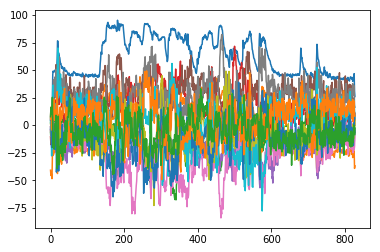

In [27]:
plt.plot(mfcc)

## сделаем основу - кастомный датасет

In [12]:
AUDIO_DIR = "./cv-corpus-7.0-2021-07-21/ru/clips/"
ANN_FILE = 'train_preproc_balanced.csv'

class CustomAudioDataset(Dataset):

    def __init__(self, audio_dir = AUDIO_DIR, annotation_file = ANN_FILE, resample_freq =16000,
                 transform=None, target_transform=None, n_mels = 64):
        df = pd.read_csv(annotation_file)
        self.audio_labels = df[['path', 'gender']].copy() #pd.read_csv(annotation_file, names=['paths', 'gender'])
        print(self.audio_labels)
        self.audio_dir = audio_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resample = resample_freq
        self.n_mels = n_mels
        
    def __len__(self):
        return len(self.audio_labels)
    
    def __getitem__(self, idx):
        
#         labels = []
#         for i in range(0,len(self.audio_labels)):
#              labels.append(self.audio_labels[i, 1])

                
#         label = labels[idx]
        label = self.audio_labels.iloc[idx, 1]
        #print(label)
        #label = int(label)
        label = torch.tensor(label)
        
        audio_path = os.path.join(self.audio_dir, self.audio_labels.iloc[idx, 0])
        waveform , sr = torchaudio.load(audio_path)
        
#         waveform = torch.reshape(waveform, (1, waveform.shape[0]))
        
        if self.resample > 0:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.resample)
            waveform = resample_transform(waveform)
        
#         specgram = torchaudio.transforms.Spectrogram()(waveform)
#         # convert 1 channel to 3 channels applying imagenet models
#         specgram = specgram.repeat(3, 1, 1)
#         if self.transform:
#             #probably, we have to do transpose
#             specgram = self.transform(specgram)
#         if self.target_transform:
#             label = self.target_transform(label)
            
            
        melspectrogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate=self.resample, n_mels=self.n_mels)
        melspectrogram = melspectrogram_transform(waveform)
        melspectogram_db = torchaudio.transforms.AmplitudeToDB()(melspectrogram)
        #print(melspectogram_db.shape)
        #Make sure all spectrograms are the same size
        fixed_length = 3 * (self.resample//100) #//200
        if melspectogram_db.shape[2] < fixed_length:
            melspectogram_db = torch.nn.functional.pad(
              melspectogram_db, (0, fixed_length - melspectogram_db.shape[2]))
        else:
            melspectogram_db = melspectogram_db[:, :, :fixed_length]

        return melspectogram_db, label #soundData, self.resample, melspectogram_db, self.labels[index]
        
#         return specgram, label

In [37]:
df = pd.read_csv('train_preproc_balanced.csv')
df.dtypes
df = df.sample(5556)
train_df = df[0:4556]
val_df = df[4556:]

In [40]:
# df.isna().sum()

Unnamed: 0    0
client_id     0
path          0
gender        0
dtype: int64

In [38]:
# train_df.gender.value_counts()

1    2469
0    2087
Name: gender, dtype: int64

In [5]:
# val_df.head()

In [41]:
train_df.to_csv('train_part.csv')
val_df.to_csv('val_part.csv')

In [13]:
train_dataset = CustomAudioDataset(annotation_file = 'train_part.csv')
val_dataset = CustomAudioDataset(annotation_file = 'val_part.csv')

                              path  gender
0     common_voice_ru_19348204.mp3       1
1     common_voice_ru_26096461.mp3       0
2     common_voice_ru_21442369.mp3       1
3     common_voice_ru_18932545.mp3       0
4     common_voice_ru_18930487.mp3       0
...                            ...     ...
4551  common_voice_ru_21932268.mp3       1
4552  common_voice_ru_24455277.mp3       0
4553  common_voice_ru_20984717.mp3       1
4554  common_voice_ru_20415228.mp3       1
4555  common_voice_ru_23976328.mp3       0

[4556 rows x 2 columns]
                             path  gender
0    common_voice_ru_18932807.mp3       0
1    common_voice_ru_21715318.mp3       0
2    common_voice_ru_18881237.mp3       1
3    common_voice_ru_18914271.mp3       0
4    common_voice_ru_20454779.mp3       0
..                            ...     ...
995  common_voice_ru_24455370.mp3       0
996  common_voice_ru_18919711.mp3       0
997  common_voice_ru_18922429.mp3       0
998  common_voice_ru_18858406.mp3      

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)

In [15]:
16000/400

40.0

In [16]:
batch, lab = next(iter(train_dataloader))
lab

tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1])

In [17]:
!nvidia-smi

Sun Jan  9 11:10:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    55W / 300W |   7621MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [18]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu') 
classes =2 

model = models.resnet18(pretrained=True)
model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                      kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], 
                      padding=model.conv1.padding[0])
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 8, gamma = 0.1)
criterion = nn.CrossEntropyLoss()

In [19]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, scheduler= None,
                savename='ADDITIONAL_TASK_BEST', is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

#                     if is_inception and phase == 'train':
#                         # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
#                         outputs, aux_outputs = model(inputs)
#                         loss1 = criterion(outputs, labels)
#                         loss2 = criterion(aux_outputs, labels)
#                         loss = loss1 + 0.4*loss2
#                     else:
#                         outputs = model(inputs)
#                         loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase=='train':
                scheduler.step()
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), savename+'.pt')
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history



In [20]:
dataloaders = {'train': train_dataloader, 'val': val_dataloader}

In [22]:
model, val_acc_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=3,scheduler= scheduler, 
            savename='MelsSpecsResnet', is_inception=False)
    


Epoch 0/2
----------


100%|██████████| 285/285 [00:15<00:00, 18.42it/s]


train Loss: 0.0106 Acc: 0.9974


100%|██████████| 63/63 [00:03<00:00, 17.15it/s]


val Loss: 0.0101 Acc: 0.9980

Epoch 1/2
----------


100%|██████████| 285/285 [00:14<00:00, 19.20it/s]


train Loss: 0.0034 Acc: 0.9993


100%|██████████| 63/63 [00:03<00:00, 16.78it/s]


val Loss: 0.0061 Acc: 0.9990

Epoch 2/2
----------


100%|██████████| 285/285 [00:15<00:00, 18.63it/s]


train Loss: 0.0037 Acc: 0.9989


100%|██████████| 63/63 [00:03<00:00, 16.70it/s]

val Loss: 0.0058 Acc: 0.9990

Training complete in 0m 57s
Best val Acc: 0.999000


In [24]:
test_dataset = CustomAudioDataset(annotation_file = 'test_dropna.csv')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

                              path  gender
0     common_voice_ru_26778765.mp3       0
1     common_voice_ru_27058803.mp3       1
2     common_voice_ru_26807715.mp3       0
3     common_voice_ru_26774623.mp3       0
4     common_voice_ru_19921774.mp3       1
...                            ...     ...
3848  common_voice_ru_25157427.mp3       1
3849  common_voice_ru_25157428.mp3       1
3850  common_voice_ru_25157430.mp3       1
3851  common_voice_ru_25157431.mp3       1
3852  common_voice_ru_25157433.mp3       1

[3853 rows x 2 columns]


In [81]:
model = model.eval()
phase = 'test'
running_loss = 0.0
running_corrects = 0
y = []
y_pred_0 = []
y_pred_1 = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    y.append(list(labels.view(-1).detach().cpu()))

    optimizer.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        m = nn.Softmax(dim=1)
        q = m(outputs)
        
        y_pred_0.append(list(q[:,0].detach().cpu()))
        y_pred_1.append(list(q[:,1].detach().cpu()))
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        y_pred.append(preds.view(-1))

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / len(test_dataloader.dataset)
epoch_acc = running_corrects.double() / len(test_dataloader.dataset)

print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


# # deep copy the model
# if phase == 'val' and epoch_acc > best_acc:
#     best_acc = epoch_acc
#     best_model_wts = copy.deepcopy(model.state_dict())
#     torch.save(model.state_dict(), savename+'.pt')
# if phase == 'val':
#     val_acc_history.append(epoch_acc)

100%|██████████| 241/241 [00:13<00:00, 17.60it/s]

test Loss: 0.2547 Acc: 0.9390


In [82]:
def flatten(t):
    return [float(item) for sublist in t for item in sublist]

In [86]:
y = flatten(y)

In [87]:
y_pred_1 = flatten(y_pred_1)

In [88]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, y_pred_1)

0.9635376813092809

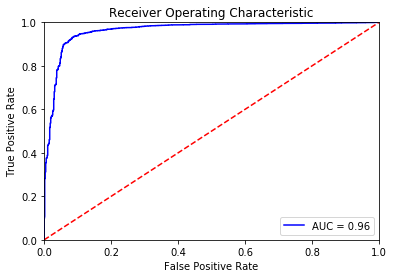

In [89]:
import sklearn.metrics as metrics

preds = y_pred_1
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_auc.pdf')
plt.show()


## Приемлимо для обучения за 3 минуты

In [90]:
!pip freeze

absl-py==0.15.0
adversarial-robustness-toolbox==1.5.0
alabaster==0.7.12
apex==0.1
appdirs==1.4.4
asn1crypto==0.24.0
astunparse==1.6.3
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.8
Babel==2.7.0
backcall==0.1.0
backpack-for-pytorch==1.3.0
beautifulsoup4==4.7.1
black==19.10b0
bleach==3.1.0
blessings==1.7
boto3==1.9.185
botocore==1.12.185
cached-property==1.5.2
cachetools==4.2.4
certifi==2019.6.16
cffi==1.12.3
cfgv==3.3.1
chardet==3.0.4
charset-normalizer==2.0.9
clang==5.0
Click==7.0
cma==3.1.0
codecov==2.0.15
conda==4.7.5
conda-build==3.18.5
conda-package-handling==1.3.10
coverage==4.5.3
cryptography==2.7
cycler==0.10.0
cymem==2.0.2
Cython==0.28.4
cytoolz==0.9.0.1
dataclasses==0.8
DataProperty==0.43.1
decorator==4.4.0
defusedxml==0.6.0
dill==0.2.9
distlib==0.3.4
docutils==0.14
eagerpy==0.29.0
einops==0.3.2
entrypoints==0.3
ffmpeg==1.4
ffmpeg-python==0.2.0
ffprobe==0.5
filelock==3.2.0
flake8==3.7.9
Flask==1.1.1
foolbox==3.3.1
future==0.17.1
gdown==4.2.0
gitdb==4.0.9
GitPython==3.1.20


In [91]:
!pip list

Package                        Version     
------------------------------ ------------
absl-py                        0.15.0      
adversarial-robustness-toolbox 1.5.0       
alabaster                      0.7.12      
apex                           0.1         
appdirs                        1.4.4       
asn1crypto                     0.24.0      
astunparse                     1.6.3       
atomicwrites                   1.3.0       
attrs                          19.1.0      
audioread                      2.1.8       
Babel                          2.7.0       
backcall                       0.1.0       
backpack-for-pytorch           1.3.0       
beautifulsoup4                 4.7.1       
black                          19.10b0     
bleach                         3.1.0       
blessings                      1.7         
boto3                          1.9.185     
botocore                       1.12.185    
cached-property                1.5.2       
cachetools                     4

In [92]:
!pip freeze > requirements.txt

# References
* https://medium.com/analytics-vidhya/how-to-classify-sounds-using-pytorch-27c9f2d4d714
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* https://towardsdatascience.com/audio-classification-with-pytorchs-ecosystem-tools-5de2b66e640c
* https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
* https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python